In [2]:
# Importo librerias necesarias
import warnings
warnings.filterwarnings("ignore")
import numpy as np # librería para poder usar arreglos
import pandas as pd # librería para poder usad DataFrames (tablas)
import plotly.express as px
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot
import sklearn # librería para poder usar modelos de machine learning

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


In [4]:
def get_data():
    """
    Funcion para obtener los datos del archivo covid.csv
    """

    dataSet = pd.read_csv("covid.csv", header=0)
    dataSet.set_index('date', inplace=True)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def infoData(dataSet):
    """
    Funcion para obtener datos generales
    """

    print(dataSet.head(10))
    print("")
    print(dataSet.info())
    print("")
    print(dataSet.isnull().sum())
    print("")

In [5]:
data = get_data()
infoData(data)


            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26               0                0                    0         0   
2020-02-27               0                0                    0         0   
2020-02-28               0                0                    0         0   
2020-02-29               0                0                    0         0   
2020-03-01               0                0                    0         0   
2020-03-02               0                0                    0         0   
2020-03-03               0                0                    0         0   
2020-03-04               0                0                    0         0   
2020-03-05               0                0                    0         0   
2020-03-06               0                0                    0         0   

            CHIAPAS  CHIHUAHUA  DISTRITO FEDERAL  COAHUILA  COL

In [6]:
def preprocess_data(dataSet):
    """
    Funcion para el preprocesamiento de datos
    """

    local_dataSet = dataSet.dropna()
    columns_list = dataSet.columns.tolist()
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(local_dataSet)
    new_dataSet = min_max_scaler.transform(local_dataSet)

    new_dataSet = pd.DataFrame(np.round(new_dataSet,4), columns=columns_list)
    new_dataSet.index = local_dataSet.index

    return new_dataSet

def getCorr(dataSet):
    """
    Funcion para obtener la matriz de correlacion
    """

    print(dataSet.head(1215))
    print("")
    print(dataSet.describe())
    print("")

    plt.figure(figsize=(10, 8))
    sns.heatmap(dataSet.corr(), annot=True, cmap='coolwarm', fmt=".2f") # Calculate correlation on the DataFrame itself
    plt.title('Matriz de Correlación', fontweight='bold')
    plt.show()

            AGUASCALIENTES  BAJA CALIFORNIA  BAJA CALIFORNIA SUR  CAMPECHE  \
date                                                                         
2020-02-26          0.0000           0.0000               0.0000    0.0000   
2020-02-27          0.0000           0.0000               0.0000    0.0000   
2020-02-28          0.0000           0.0000               0.0000    0.0000   
2020-02-29          0.0000           0.0000               0.0000    0.0000   
2020-03-01          0.0000           0.0000               0.0000    0.0000   
...                    ...              ...                  ...       ...   
2023-06-20          0.0020           0.0088               0.0009    0.0073   
2023-06-21          0.0013           0.0078               0.0028    0.0049   
2023-06-22          0.0033           0.0062               0.0009    0.0000   
2023-06-23          0.0000           0.0020               0.0014    0.0170   
2023-06-24          0.0000           0.0000               0.0000

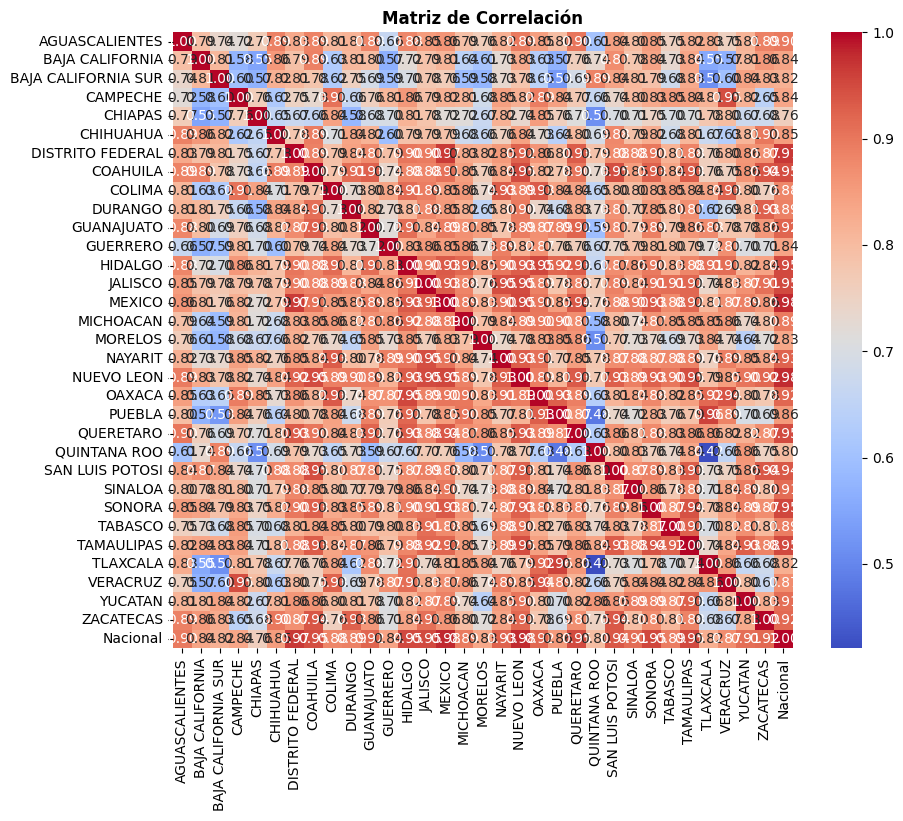

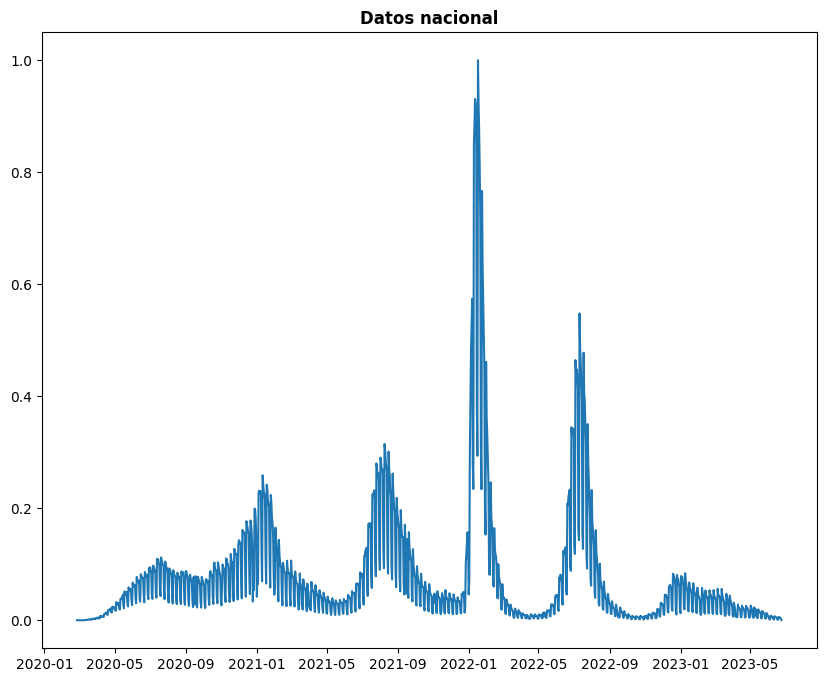

In [7]:
preprocessData = preprocess_data(data)
getCorr(preprocessData)

plt.figure(figsize=(10, 8))
plt.plot(preprocessData['Nacional'])
plt.title('Datos nacional', fontweight='bold')
plt.show()

In [8]:
def pca_Transformation(dataSet):
    features = dataSet
    features = features.drop(['Nacional'], axis=1)

    # principal components analysis
    pca = sk.PCA(n_components=3)
    principalComponents = pca.fit_transform(features)
    principalComp = pd.DataFrame(data = principalComponents,
                                 columns = ['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3'])
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp['Nacional'] = dataSet['Nacional']
    cols = principalComp.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    principalComp = principalComp[cols]

    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    varRatio = (pca.explained_variance_ratio_)*100
    data = {'P. Comp. 1':varRatio[0],'P. Comp. 2':varRatio[1],'P. Comp. 3':varRatio[2]}
    dfVar = pd.DataFrame(data, index=['Exp Var Ratio %'])
    print(dfVar)
    print("\n")

    return principalComp

In [9]:
pcaData = pca_Transformation(preprocessData)
pcaData.head(1215)

                 PCA ANALYSIS
----------------------------------------------------------
            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2023-06-20    0.0055   -0.385418   -0.023980   -0.031617
2023-06-21    0.0050   -0.389817   -0.025970   -0.026036
2023-06-22    0.0048   -0.394643   -0.029628   -0.022447
2023-06-23    0.0026   -0.401546   -0.021571   -0.028535
2023-06-24    0.0002   -0.419864   -0.024882   -0.014331

[1215 rows x 4 columns]


                 P. Comp. 1  P. Comp. 2  P. Comp. 3
Exp Var Ratio %   81.101835    5.824434    3.614026




,Nacional,P. Comp. 1,P. Comp. 2,P. Comp. 3
date,,,,
2020-02-26,0.0000,-0.420984,-0.025472,-0.013954
2020-02-27,0.0000,-0.420786,-0.025421,-0.013903
2020-02-28,0.0000,-0.420896,-0.025544,-0.013894
2020-02-29,0.0000,-0.420792,-0.025320,-0.014072
2020-03-01,0.0000,-0.420784,-0.025356,-0.013891
...,...,...,...,...
2023-06-20,0.0055,-0.385418,-0.023980,-0.031617
2023-06-21,0.0050,-0.389817,-0.025970,-0.026036
2023-06-22,0.0048,-0.394643,-0.029628,-0.022447


In [10]:
train_data, test_data = train_test_split(pcaData, test_size=0.25, shuffle=False)
print(train_data.head(1215))
print("")
print(len(train_data))
print("")
print(test_data.head(1215))
print("")
print(len(test_data))

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2020-02-26    0.0000   -0.420984   -0.025472   -0.013954
2020-02-27    0.0000   -0.420786   -0.025421   -0.013903
2020-02-28    0.0000   -0.420896   -0.025544   -0.013894
2020-02-29    0.0000   -0.420792   -0.025320   -0.014072
2020-03-01    0.0000   -0.420784   -0.025356   -0.013891
...              ...         ...         ...         ...
2022-08-20    0.0210   -0.287385    0.002451    0.002460
2022-08-21    0.0187   -0.293690    0.000125    0.009103
2022-08-22    0.0691   -0.015549    0.005202    0.060701
2022-08-23    0.0507   -0.102404    0.010890    0.055541
2022-08-24    0.0462   -0.132828    0.019228    0.046232

[911 rows x 4 columns]

911

            Nacional  P. Comp. 1  P. Comp. 2  P. Comp. 3
date                                                    
2022-08-25    0.0404   -0.171591    0.015264    0.020806
2022-08-26    0.0362   -0.204175    0.005791    0.015538
2

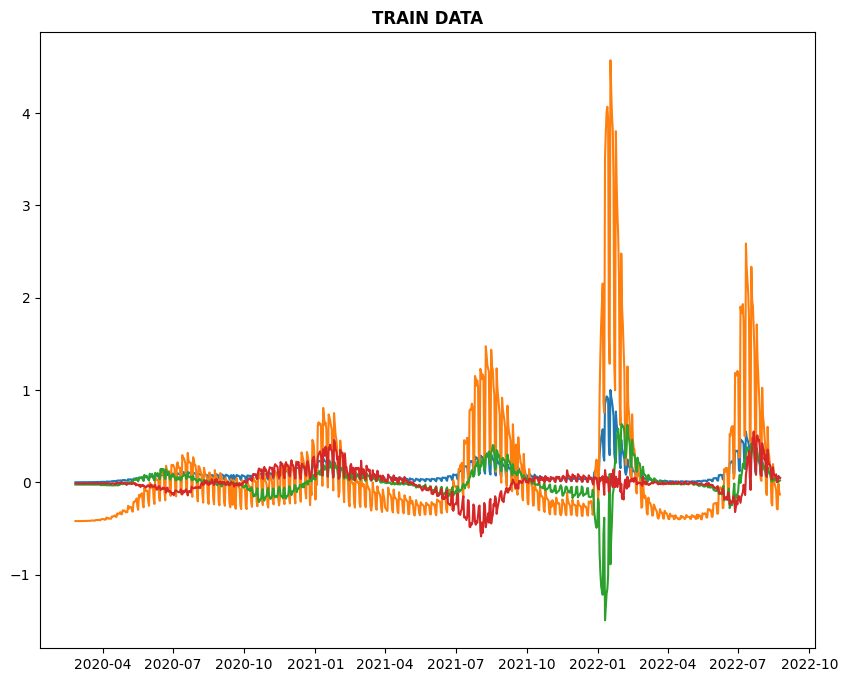

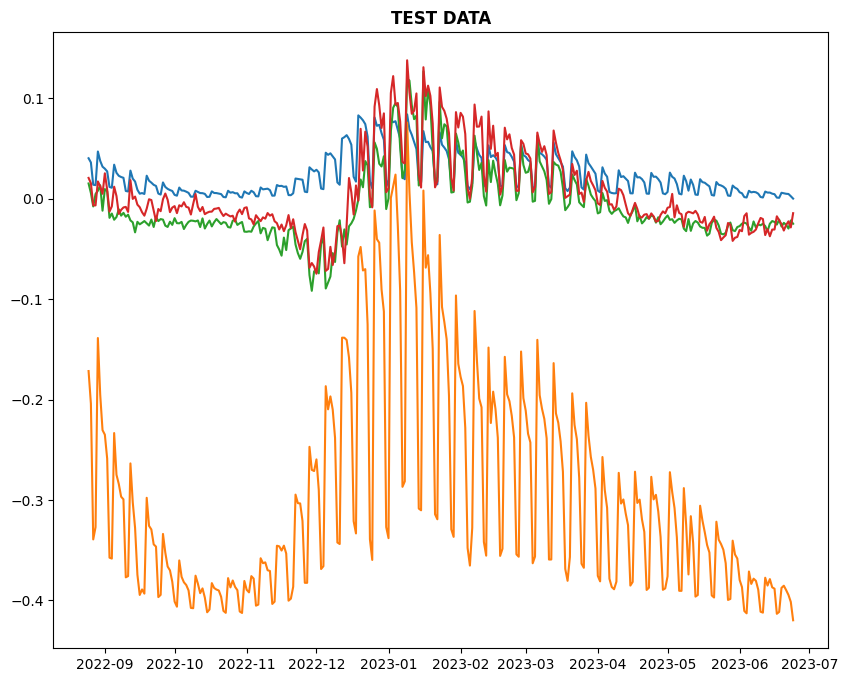

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(train_data)
plt.title('TRAIN DATA', fontweight='bold')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(test_data)
plt.title('TEST DATA', fontweight='bold')
plt.show()

Modelado del PCA

In [63]:
# Decision Tree Regressor
dt_regr = DecisionTreeRegressor()
param_search_dt_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}
# Puedo probar con'min_samples_split': [2, 5, 10],
# Puedo probar con'min_samples_leaf': [1, 2, 4]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_dt.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_dt = grid_search_dt.best_params_

print("==========================================================")
print("Best parameters for Decision Tree Regressor:")
print(best_params_dt)
print("----------------------------------------------------------")


Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best parameters for Decision Tree Regressor:
{'criterion': 'squared_error', 'max_depth': 3}
----------------------------------------------------------


In [64]:
# === Definición de variables (X e Y) ===
X_train = train_data.iloc[:, [-1]]  # Nacional
Y_train = train_data.iloc[:, 0:3]  # P. Comp. 1, 2, 3

X_test = test_data.iloc[:, [-1]]
Y_test = test_data.iloc[:, 0:3]

In [65]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_dt = MultiOutputRegressor(grid_search_dt.best_estimator_)
multi_dt.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_dt.predict(X_train)
test_pred = multi_dt.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.013354  0.059005  1.496964e+12  0.181686  0.115557 -1344.548147   
P. Comp. 2  0.360649  0.319649  2.446717e+00  0.198981  0.600541  1658.223094   
P. Comp. 3  0.030319  0.092962  2.003629e+00  0.132981  0.174125  -597.518241   

                 APC          BIC  
P. Comp. 1  0.013368 -1339.733604  
P. Comp. 2  0.361045  1663.037637  
P. Comp. 3  0.030353  -592.703698  

 Métricas por componente - Test:
                 MSE       MAE      MAPE        R2      RMSE         AIC  \
P. Comp. 1  0.002427  0.046967  7.116137 -4.784790  0.049269 -965.642393   
P. Comp. 2  0.075876  0.265464  2.093481 -5.581120  0.275456   80.802739   
P. Comp. 3  0.004581  0.049675  2.209206 -2.485007  0.067684 -772.571733   

                 APC         BIC  
P. Comp. 1  0.002435 -961.925365  
P. Comp. 2  0.076125   84.519767  
P. Comp. 3  0.004596 -768.854705  


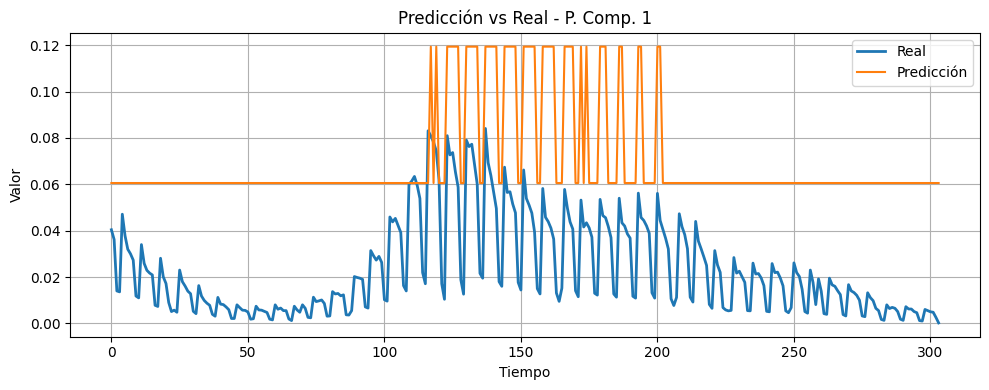

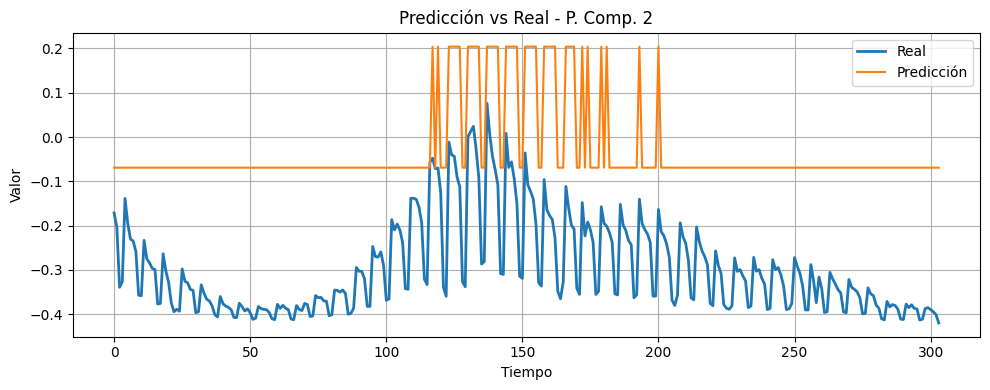

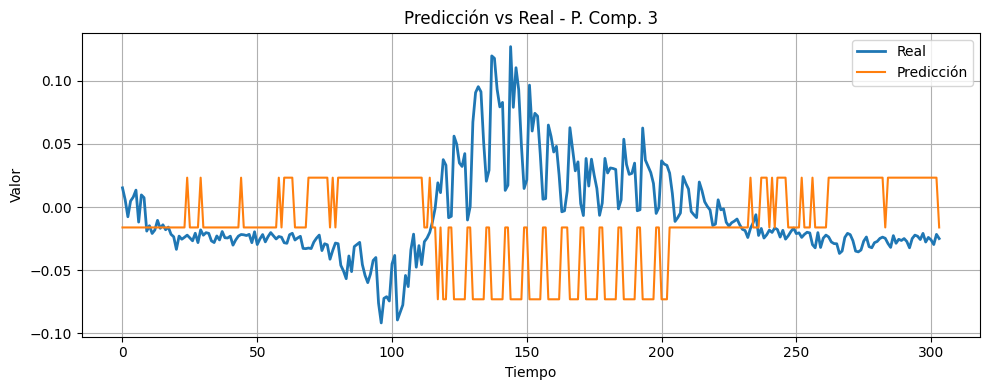

In [66]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [68]:
# Random forest
rf_regr = RandomForestRegressor()
param_search_rf_regr = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'], #Puedo añadir 'friedman_mse',
    'n_estimators': [10, 50, 100, 200, None], # Puedo probar con [10, 50, 100, 200, 500]
    'max_depth': [3, 5, 7, 9, 15, 20, None]
}

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

grid_search_rf = GridSearchCV(estimator=rf_regr, param_grid=param_search_rf_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_rf.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_rf = grid_search_rf.best_params_

print("==========================================================")
print("Best parameters for Decision Tree Regressor:")
print(best_params_rf)
print("----------------------------------------------------------")


Fitting 5 folds for each of 105 candidates, totalling 525 fits
Best parameters for Decision Tree Regressor:
{'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
----------------------------------------------------------


In [69]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_rf = MultiOutputRegressor(grid_search_rf.best_estimator_)
multi_rf.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_rf.predict(X_train)
test_pred = multi_rf.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.012450  0.057261  1.381843e+12  0.237056  0.111579 -1408.374385   
P. Comp. 2  0.349511  0.318939  2.334847e+00  0.223719  0.591195  1629.644982   
P. Comp. 3  0.029646  0.092733  1.650916e+00  0.152235  0.172181  -617.977358   

                 APC          BIC  
P. Comp. 1  0.012464 -1403.559842  
P. Comp. 2  0.349895  1634.459525  
P. Comp. 3  0.029679  -613.162815  

 Métricas por componente - Test:
                 MSE       MAE      MAPE        R2      RMSE         AIC  \
P. Comp. 1  0.002299  0.046130  6.666349 -4.479056  0.047950 -982.149366   
P. Comp. 2  0.073723  0.265320  2.154338 -5.394381  0.271519   72.052048   
P. Comp. 3  0.003958  0.047129  1.855192 -2.011004  0.062913 -817.015487   

                 APC         BIC  
P. Comp. 1  0.002307 -978.432338  
P. Comp. 2  0.073965   75.769075  
P. Comp. 3  0.003971 -813.298460  


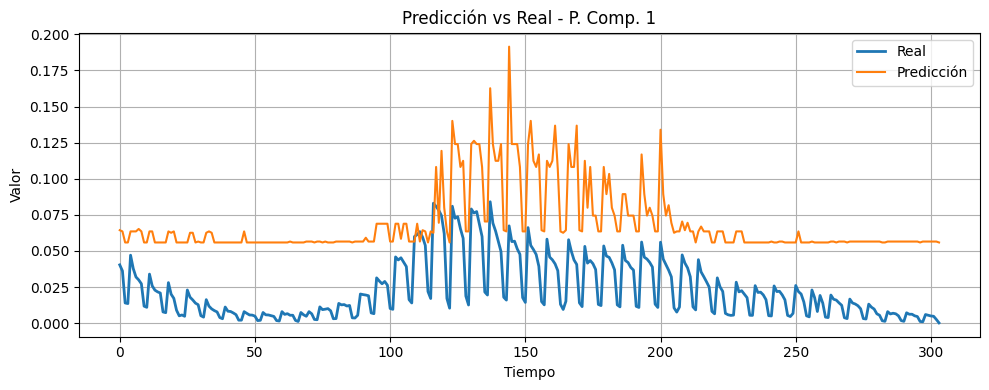

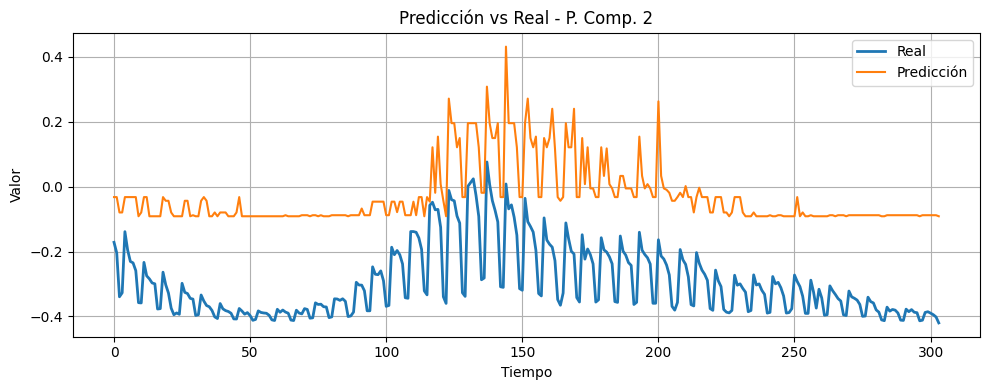

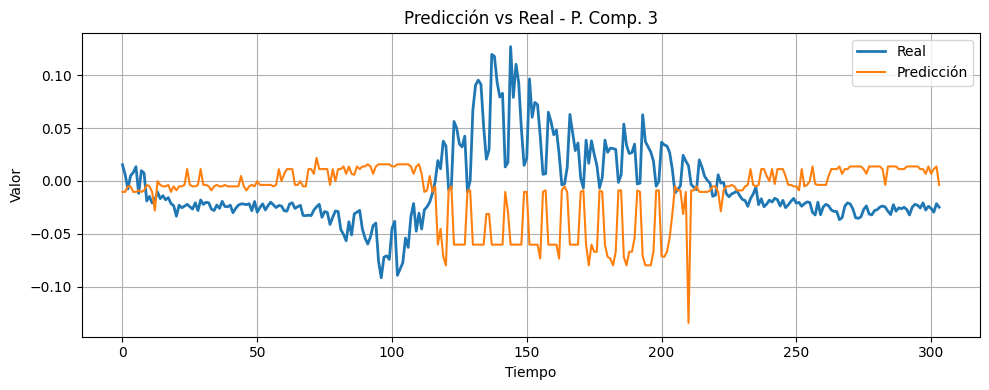

In [70]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [73]:
# Support Vector Machine
svm_regr = svm.SVR()
param_search_svm_regr = {
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree': [2, 3, 4, 5, 6]  # 'C': [0.1, 1, 10, 100],
}
# Puedo agregar: 'estimator__gamma': ['scale', 'auto'], # Puedo probar con [0.001, 0.01, 0.1, 1]
# Puedo agregar: 'estimator__epsilon': [0.1, 0.2, 0.5, 1]

# Utilizo GridSearchCV para encontrar los mejores parámetros
# Definir X (característica) y y (objetivo)
X = train_data[['Nacional']]
y = train_data[['P. Comp. 1', 'P. Comp. 2', 'P. Comp. 3']]

multioutput_svm = MultiOutputRegressor(svm_regr)
grid_search_svm = GridSearchCV(estimator=multioutput_svm, param_grid=param_search_svm_regr, n_jobs=-1, cv=5, verbose=1)
grid_search_svm.fit(X, y)  # Entreno el modelo con la columna 'Nacional' como característica y los componentes principales como objetivo
best_params_svm = grid_search_svm.best_params_

print("==========================================================")
print("Best parameters for Support Vector Machine:")
print(best_params_svm)
print("----------------------------------------------------------")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [37]:
# === MultiOutputRegressor para predecir los 3 componentes principales ===
multi_svm = MultiOutputRegressor(grid_search_svm.best_estimator_)
multi_svm.fit(X_train, Y_train)

# === Predicciones ===
train_pred = multi_svm.predict(X_train)
test_pred = multi_svm.predict(X_test)

# === Convertir a DataFrames para análisis ===
pred_train_df = pd.DataFrame(train_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_train.index)
pred_test_df = pd.DataFrame(test_pred, columns=["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"], index=Y_test.index)

Y_train.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
Y_test.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_train_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]
pred_test_df.columns = ["P. Comp. 1", "P. Comp. 2", "P. Comp. 3"]

# === Utilizando el mismo proceso de evaluación como en la primer tarea, el cambio ahora es que se usa para los 3 componentes del análisis PCA ===
def evaluacion_metricas(true_df, pred_df):
    metrics = {}
    for col in true_df.columns:
        n = len(true_df[col])
        k = 1  # number of predictors (for each PCA component, only one output, but you may adjust if needed)
        mse = mean_squared_error(true_df[col], pred_df[col])
        mae = mean_absolute_error(true_df[col], pred_df[col])
        mape = mean_absolute_percentage_error(true_df[col], pred_df[col])
        r2 = r2_score(true_df[col], pred_df[col])
        rmse = mse ** 0.5

        # AIC and BIC for regression (assuming Gaussian errors)
        # log-likelihood for Gaussian: -n/2 * log(2*pi*sigma^2) - (1/(2*sigma^2)) * sum((y-yhat)^2)
        # For AIC/BIC, sigma^2 is estimated as mse
        if mse > 0:
            log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - n / 2
            aic = 2 * k - 2 * log_likelihood
            bic = np.log(n) * k - 2 * log_likelihood
        else:
            aic = np.nan
            bic = np.nan

        # Amemiya's Prediction Criterion (APC)
        # APC = (1 + (k/n)) * mse
        apc = (1 + (k / n)) * mse

        metrics[col] = {
            "MSE": mse,
            "MAE": mae,
            "MAPE": mape,
            "R2": r2,
            "RMSE": rmse,
            "AIC": aic,
            "APC": apc,
            "BIC": bic
        }
    return pd.DataFrame(metrics).T

train_metrics = evaluacion_metricas(Y_train, pred_train_df)
test_metrics = evaluacion_metricas(Y_test, pred_test_df)

print("\n Métricas por componente - Train:")
print(train_metrics)
print("\n Métricas por componente - Test:")
print(test_metrics)


 Métricas por componente - Train:
                 MSE       MAE          MAPE        R2      RMSE          AIC  \
P. Comp. 1  0.007427  0.083851  2.455946e+12  0.544891  0.086178 -1879.040824   
P. Comp. 2  0.006630  0.078495  1.256933e+00  0.985275  0.081423 -1982.444403   
P. Comp. 3  0.000745  0.023031  1.415525e+00  0.978700  0.027292 -3973.997860   

                 APC          BIC  
P. Comp. 1  0.007435 -1874.226281  
P. Comp. 2  0.006637 -1977.629860  
P. Comp. 3  0.000746 -3969.183317  

 Métricas por componente - Test:
                 MSE       MAE       MAPE         R2      RMSE          AIC  \
P. Comp. 1  0.008943  0.094386  12.864205 -20.311760  0.094567  -569.218188   
P. Comp. 2  0.008815  0.093732   0.784338   0.235441  0.093887  -573.606242   
P. Comp. 3  0.000532  0.022332   2.003159   0.595027  0.023073 -1426.902778   

                 APC          BIC  
P. Comp. 1  0.008972  -565.501160  
P. Comp. 2  0.008844  -569.889214  
P. Comp. 3  0.000534 -1423.185750  


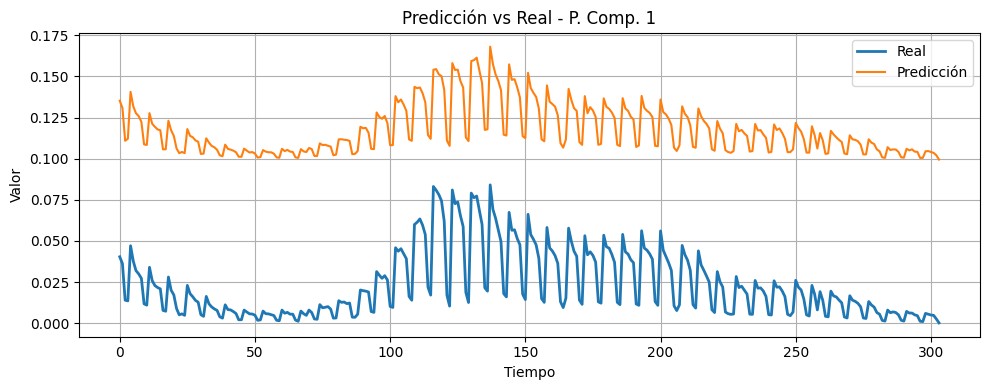

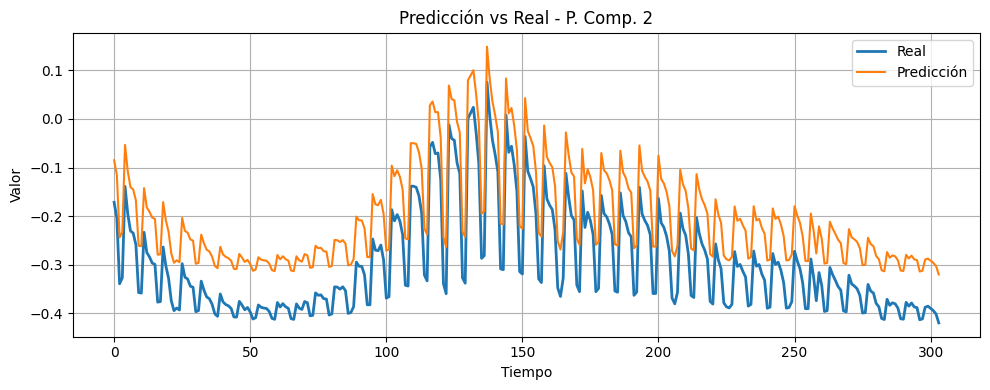

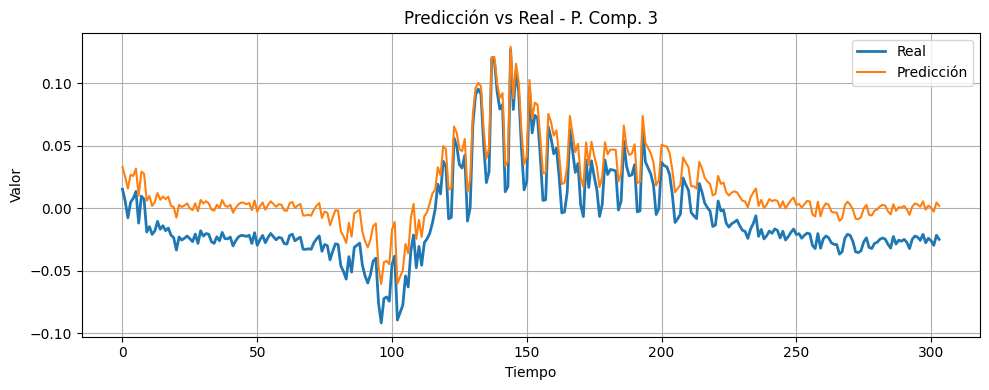

In [38]:
# == Gráfica de cada componente en test ==
for col in Y_test.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test[col].values, label="Real", linewidth=2)
    plt.plot(pred_test_df[col].values, label="Predicción", linestyle="-")
    plt.title(f"Predicción vs Real - {col}")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()